In [1]:
import os

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
os.environ['HYDRA_CONFIG_PATH'] = '/Users/felix/Programming/TUM/Diffusion-3D-Features/sam2_download/sam2/configs'

In [2]:
import torch
from diff3f import get_features_per_vertex, arange_pixels
from time import time
from utils import convert_mesh_container_to_torch_mesh, cosine_similarity, double_plot, get_colors, generate_colors
from dataloaders.mesh_container import MeshContainer
from diffusion import init_pipe
from dino import init_dino, get_dino_features, init_sam, get_sam_features
from functional_map import compute_surface_map

/opt/homebrew/anaconda3/envs/diff3f/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [3]:
# device = torch.device('cuda:0')
# device = torch.device("mps")
# torch.cuda.set_device(device)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
num_views = 100
H = 512
W = 512
num_images_per_prompt = 1
tolerance = 0.004
random_seed = 42
use_normal_map = True

In [4]:
from PIL import Image

# Load a jpg image from test/assets
image_path = "test_assets/sample.jpg"
img = Image.open(image_path).convert("RGB")

# Display the image to verify it loaded correctly
# img.show()


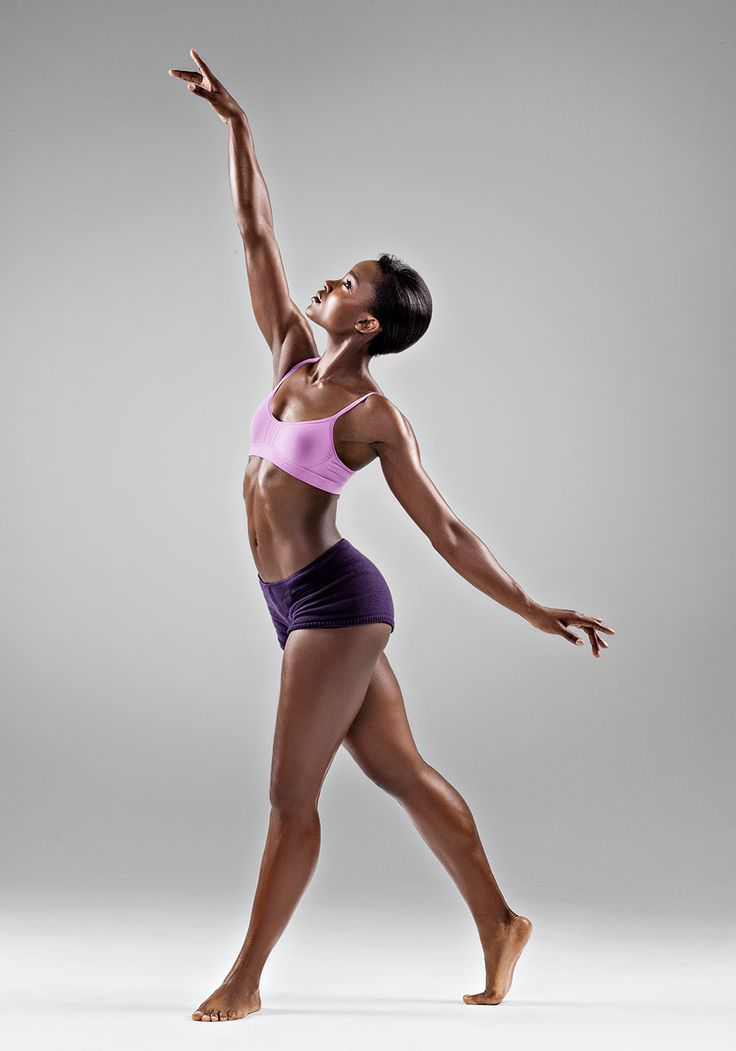

In [5]:
img

In [6]:
dino_model = init_dino(device)
sam_model = init_sam(device)


Using cache found in /Users/felix/.cache/torch/hub/facebookresearch_dinov2_main
/Users/felix/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/felix/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/felix/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [7]:
H = 512; W = 512
grid = arange_pixels((H, W), invert_y_axis=False)[0].to(device).reshape(1, H, W, 2).half()

dino_features = get_dino_features(device, dino_model, img, grid)
# sam_features = get_sam_features(device, sam_model, img, grid, layer_index=12)

/opt/homebrew/anaconda3/envs/diff3f/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
dino_features

tensor([[[-0.0089, -0.0180, -0.0139,  ...,     nan,     nan,     nan],
         [-0.0114, -0.0275,  0.0169,  ...,     nan,     nan,     nan],
         [ 0.0145,  0.0121, -0.0698,  ...,     nan,     nan,     nan],
         ...,
         [ 0.0503,  0.0334,  0.0467,  ...,     nan,     nan,     nan],
         [ 0.0503,  0.0334,  0.0467,  ...,     nan,     nan,     nan],
         [ 0.0503,  0.0334,  0.0467,  ...,     nan,     nan,     nan]]],
       device='mps:0', dtype=torch.float16)

In [9]:
sam_features = get_sam_features(device, sam_model, img, grid)

/opt/homebrew/anaconda3/envs/diff3f/lib/python3.10/site-packages/torch/nn/functional.py:4594: UserWarning: The operator 'aten::upsample_bicubic2d.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch._C._nn.upsample_bicubic2d(


In [10]:
sam_features

tensor([[[-0.0298, -0.0290, -0.0303,  ..., -0.0262, -0.0187, -0.0179],
         [-0.0597, -0.0580, -0.0607,  ..., -0.0524, -0.0373, -0.0358],
         [-0.0567, -0.0131, -0.0240,  ..., -0.0712, -0.0807, -0.0795],
         ...,
         [-0.0667, -0.0708, -0.0665,  ..., -0.0648, -0.0409, -0.0439],
         [-0.1139, -0.1441, -0.1572,  ..., -0.0122,  0.0234,  0.0166],
         [-0.1161, -0.1496, -0.1640,  ...,  0.0171,  0.0501,  0.0379]]],
       device='mps:0')

In [11]:
print(sam_features.shape)
print(dino_features.shape)


torch.Size([1, 256, 262144])
torch.Size([1, 768, 262144])
